In [1]:
import pandas as pd
import joblib
import sglearn

from model_predictions import deepspcas9_predictions, rule_set2_predictions
from datasets import dataset_list
from core import (setup_plots,
                  get_model_performance,
                  point_range_plot)

In [2]:
setup_plots()

In [3]:
model = joblib.load('../models/RuleSet3.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [4]:
dataset_activity_list = []
for ds in dataset_list:
    ds.load_data()
    dataset_activity = ds.get_sg_df(include_group=True,
                                    include_activity=True)
    dataset_activity['dataset'] = ds.name
    dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.825581,Aguirre2017
...,...,...,...,...,...,...
40344,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014
40345,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014
40346,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014
40347,TTTGTGTATTGCGGCAAGAA,CCAGTTTGTGTATTGCGGCAAGAAGGGTTA,GGG,RPL8,0.166667,Wang2014


In [5]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.set_sgrnas()
    dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                    how='inner',
                                                    on=['sgRNA Sequence',
                                                        'sgRNA Context Sequence',
                                                        'PAM Sequence'])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df


,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,25.799622,False,0.489201,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,0.784734,False,0.464962,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,32.187088,False,0.525786,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.666667,Shalem_2014,32.187088,False,0.525786,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,19.478521,False,0.369761,False
...,...,...,...,...,...,...,...,...,...,...
40344,TTTGGACTGAAAGTGCTTTC,TGCATTTGGACTGAAAGTGCTTTCCGGAAG,CGG,RPL4,0.142857,Wang2014,18.558062,False,0.362297,False
40345,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,10.168873,False,0.333939,False
40346,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,49.501511,False,0.489867,False
40347,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,40.421345,False,0.445911,False


In [6]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = sglearn.featurize_guides(dataset_activity_df['sgRNA Context Sequence'])
dataset_activity_df['Rule Set 3'] = model.predict(X)
dataset_activity_df['Rule Set 3 train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,DeepSpCas9,DeepSpCas9 train,Rule Set 2,Rule Set 2 train,Rule Set 3,Rule Set 3 train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,0.259690,Aguirre2017,25.799622,False,0.489201,False,0.284257,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,0.375969,Aguirre2017,0.784734,False,0.464962,False,0.183963,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.947674,Aguirre2017,32.187088,False,0.525786,False,0.415110,False
3,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.666667,Shalem_2014,32.187088,False,0.525786,False,0.415110,False
4,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,0.515504,Aguirre2017,19.478521,False,0.369761,False,0.158673,False
...,...,...,...,...,...,...,...,...,...,...,...,...
40344,TTTGGACTGAAAGTGCTTTC,TGCATTTGGACTGAAAGTGCTTTCCGGAAG,CGG,RPL4,0.142857,Wang2014,18.558062,False,0.362297,False,0.181926,True
40345,TTTGGGCAAACTTCTTTCTC,ATCTTTTGGGCAAACTTCTTTCTCAGGCGC,AGG,RPL7,0.250000,Wang2014,10.168873,False,0.333939,False,0.241565,True
40346,TTTGTAGAAGGTGGAGATGC,CCATTTTGTAGAAGGTGGAGATGCTGGCAA,TGG,RPL7,0.808824,Wang2014,49.501511,False,0.489867,False,0.581885,True
40347,TTTGTCTCTCTCTTCAGCAA,GTCTTTTGTCTCTCTCTTCAGCAATGGTGA,TGG,RPS4X,0.125000,Wang2014,40.421345,False,0.445911,False,0.421645,True


In [7]:
score_cols = ['Rule Set 3'] + [m.name for m in model_prediction_list]
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                      'PAM Sequence', 'sgRNA Activity',
                                                      'sgRNA Target', 'dataset'],
                                             value_vars=score_cols,
                                             var_name='model',
                                             value_name='prediction')


In [8]:
predictive_performance_ci = get_model_performance(long_predictions)

100%|██████████| 1000/1000 [01:24<00:00, 11.80it/s]


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 4 x 3 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_rs3_performance.pdf


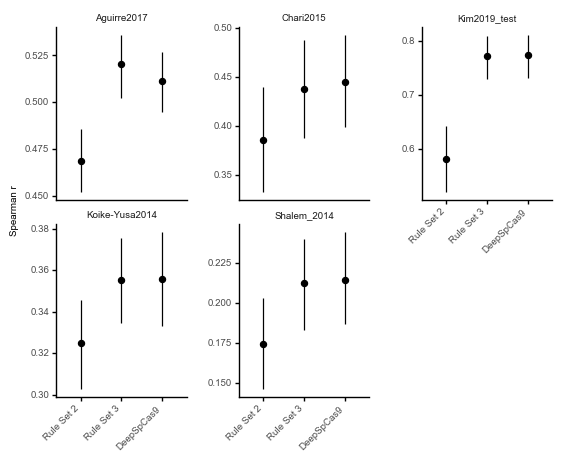

<ggplot: (8769997932361)>

In [11]:
g = point_range_plot(predictive_performance_ci, 'model', 'spearman',
                     'spearman_025', 'spearman_975', xlabel='', 
                     ylabel='Spearman r', wspace=0.4)
g.save('../figures/seq_rs3_performance.pdf', width=4, height=3)
g

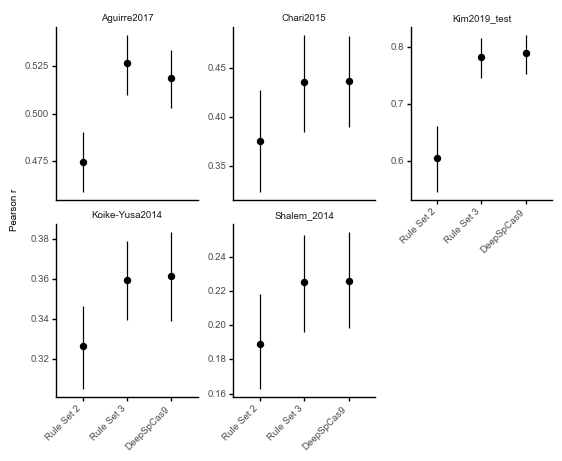

<ggplot: (8770001270029)>

In [10]:
point_range_plot(predictive_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975', xlabel='', 
                 ylabel='Pearson r')